# Imports

In [2]:
!pip install scikit-plot

In [3]:
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl
import time
from IPython.display import clear_output

from sklearn import pipeline      # Pipeline, make_pipeline
from sklearn import preprocessing # StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import inspection      # permutation_importance
import scikitplot as skplt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sb.set_style("whitegrid")
skl.set_config(display='diagram')

print("Pandas  ", pd.__version__)
print("Sklearn ", skl.__version__)

Pandas   1.2.0
Sklearn  0.24.1


In [4]:
########################################################### CLASSIFIERS

#### MULT
from sklearn.linear_model   import LogisticRegression
from sklearn.linear_model   import RidgeClassifier
from sklearn.svm            import SVC
from sklearn.svm            import NuSVC
from sklearn.svm            import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes    import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble       import StackingClassifier

#### TREE
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.experimental  import enable_hist_gradient_boosting
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier, plot_tree
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier
#from ngboost               import NGBClassifier
#from rgf.sklearn           import RGFClassifier, FastRGFClassifier

########################################################### REGRESSORS
from sklearn.linear_model  import ElasticNet, Ridge, Lasso, BayesianRidge, ARDRegression, TweedieRegressor
from sklearn.svm           import LinearSVR, NuSVR, SVR
from sklearn.ensemble      import BaggingRegressor
from sklearn.kernel_ridge  import KernelRidge

# DATA

### Read data

In [7]:
DATA_PATH = "../d1_Robust_ML/datasets/titanic/"
!ls $DATA_PATH

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
df      = pd.read_csv(DATA_PATH + "train.csv", index_col='PassengerId')
df_test = pd.read_csv(DATA_PATH + "test.csv",  index_col='PassengerId')

### Feature Generation

In [9]:
my_funtion = lambda name: name.split(',')[1].split('.')[0].strip()

df['Title']      = df['Name'].map(my_funtion)
df_test['Title'] = df_test['Name'].map(my_funtion)

df['Title'].unique(), df_test['Title'].unique(), 

(array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
        'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
        'Jonkheer'], dtype=object),
 array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
       dtype=object))

In [10]:
title_dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Dona": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

df['Title']      = df.Title.map(title_dictionary)
df_test['Title'] = df_test.Title.map(title_dictionary)

In [11]:
df.groupby(['Sex','Pclass','Title']).Age.agg(["mean","median","count"]).reset_index(drop=False)

,Sex,Pclass,Title,mean,median,count
0,female,1,Miss,29.744681,30.0,47
1,female,1,Mrs,40.400000,40.0,35
2,female,1,Officer,49.000000,49.0,1
3,female,1,Royalty,40.500000,40.5,2
4,female,2,Miss,22.390625,24.0,32
5,female,2,Mrs,33.547619,31.5,42
6,female,3,Miss,16.123188,18.0,69
7,female,3,Mrs,33.515152,31.0,33
8,male,1,Master,5.306667,4.0,3
9,male,1,Mr,41.580460,40.0,87


In [12]:
#https://towardsdatascience.com/coding-a-custom-imputer-in-scikit-learn-31bd68e541de
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class GroupImputer(BaseEstimator, TransformerMixin):

    def __init__(self, group_cols, target, metric='mean'):
        
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'
        
        self.group_cols = group_cols
        self.target = target
        self.metric = metric
    
    def fit(self, X, y=None):
        
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric).reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        return self 
    
    def transform(self, X, y=None):
        
        check_is_fitted(self, 'impute_map_') # make sure that the imputer was fitted
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind] = X.loc[ind].fillna(row[self.target])
        
        return X[[self.target]].values

### Select data for experiment

In [13]:
x = df.drop(columns=["Survived", 'Name', 'Ticket', 'Cabin']) # X DATA (WILL BE TRAIN+VALID DATA)
y = df["Survived"] # 0 = No, 1 = Yes

x_test = df_test.drop(columns=['Name', 'Ticket', 'Cabin']) # # X_TEST DATA (NEW DATA)

# PREPROCESSING

### Select numerical and categorical variables

In [14]:
cat_vars  = ['Sex', 'Embarked', 'Title']         # x.select_dtypes(include=[object]).columns.values.tolist()
num_vars  = ['Pclass', 'SibSp', 'Parch', 'Fare'] # x.select_dtypes(exclude=[object]).columns.values.tolist()
age_var   = ['Age', 'Sex', 'Pclass', 'Title']    # Imputate age by mean of grouping ['Sex', 'Pclass', 'Title']

print("\nNumerical features:\n", num_vars)
print("\nCategorical features:\n", cat_vars)


Numerical features:
 ['Pclass', 'SibSp', 'Parch', 'Fare']

Categorical features:
 ['Sex', 'Embarked', 'Title']


### Preprocessing for Mult Models

In [15]:
num_4_multModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean', add_indicator=True)), # mean, median
    ('scaler', preprocessing.StandardScaler())
])

cat_4_multModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore'))
])

age_4_multModels = pipeline.Pipeline(steps=[
    ('imputer', GroupImputer(group_cols=['Sex','Pclass','Title'], target='Age', metric='mean')),
    ('scaler', preprocessing.StandardScaler())
])

mult_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_4_multModels, num_vars),
    ('cat', cat_4_multModels, cat_vars),
    ('age', age_4_multModels, age_var),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

mult_prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True)),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked', 'Title']),
                                ('age',
                                 Pipeline(steps=[('imputer',
                                                  GroupImputer(group_cols=['Sex',
                                                                           'Pclass',
                                                                           'Title'],
                                                               target='Age')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Sex', 'Pclass', 'Title'])])

### Preprocessing for Tree Models

In [16]:
num_4_treeModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value=-9999)),
])

cat_4_treeModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', preprocessing.OrdinalEncoder()) # handle_unknown='ignore' ONLY IN VERSION 0.24
])

age_4_treeModels = pipeline.Pipeline(steps=[
    ('imputer', GroupImputer(group_cols=['Sex','Pclass','Title'], target='Age', metric='mean')),
])

tree_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_4_treeModels, num_vars),
    ('cat', cat_4_treeModels, cat_vars),
    ('age', age_4_treeModels, age_var),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

tree_prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=-9999,
                                                                strategy='constant'))]),
                                 ['Pclass', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Sex', 'Embarked', 'Title']),
                                ('age',
                                 Pipeline(steps=[('imputer',
                                                  GroupImputer(group_cols=['Sex',
                                                                           'Pclass',
                                                                           'Title'],
                                                               target='Age'))]),
                                 ['Age', 'Sex', 'Pclass', 'Title'])])

# Models

In [17]:
"""
ensemble = [
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    make_pipeline(StandardScaler(), RidgeClassifier()),
    make_pipeline(StandardScaler(), LinearSVC(random_state=42))
]

ensemble2 = [
    ('RF',    RandomForestClassifier(n_estimators=50, random_state=42)),
    ("Ridge", make_pipeline(StandardScaler(), RidgeClassifier())),
    ("SVM_rbf", make_pipeline(StandardScaler(), SVC(kernel='linear')))
]
"Stacking":       StackingClassifier(estimators=ensemble2, final_estimator=LogisticRegression()),
"""

mult_classifiers = {
  "LogRegr":        LogisticRegression(),
  #"Ridge":          RidgeClassifier(),
  "SVM_lin":         SVC(kernel="linear", probability=True), # C=0.025
  "SVM_rbf":         SVC(kernel='rbf', probability=True),
  "NuSVC":           NuSVC(probability=True),
  #"LinearSVC":       LinearSVC(),
  "KNN3":            KNeighborsClassifier(3),
  "KNN5":            KNeighborsClassifier(5),
# "GP":              GaussianProcessClassifier(1.0 * RBF(1.0)),
# "GaussianNB":      GaussianNB()
}

tree_classifiers = {
  "Decision Tree": DecisionTreeClassifier(),
  "Extra Trees":   ExtraTreesClassifier(n_estimators=100),
  "Random Forest": RandomForestClassifier(n_estimators=100),
  "AdaBoost":      AdaBoostClassifier(n_estimators=100),
  "Skl GBM":       GradientBoostingClassifier(n_estimators=100),
  "Skl HistGBM":   HistGradientBoostingClassifier(),
  "XGBoost":       XGBClassifier(n_estimators=100),
  "LightGBM":      LGBMClassifier(n_estimators=100),
  "CatBoost":      CatBoostClassifier(n_estimators=100),
# "NGBoost":       NGBClassifier(n_estimators=100),
# "RGF":           RGFClassifier(n_jobs=-1),
# "FastRGF":       FastRGFClassifier())
}


mult_classifiers = {name: pipeline.make_pipeline(mult_prepro, model) for name, model in mult_classifiers.items()}
tree_classifiers = {name: pipeline.make_pipeline(tree_prepro, model) for name, model in tree_classifiers.items()}

models = {**mult_classifiers, **tree_classifiers} # mult_classifiers | tree_classifiers  IN PYTHON 3.9+

# Do the experiment

In [18]:
preds = {}
skf = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'AUC': [], 'Time': []})


preds_abs = {}
preds_pro = {}

for model_name, model in models.items(): 
            
    start_time = time.time()
    pred_abs = model_selection.cross_val_predict(model, x, y, cv=skf)
    total_time = time.time() - start_time
    preds_abs[model_name] = pred_abs
    
    start_time = time.time()
    pred_pro = model_selection.cross_val_predict(model, x, y, cv=skf, method="predict_proba")[:,1]
    total_time = time.time() - start_time
    preds_pro[model_name] = pred_pro
    
    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y, pred_abs)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y, pred_abs)*100,
                              "AUC":      metrics.roc_auc_score(y, pred_pro)*100,
                              "Time":     total_time},
                              ignore_index=True)
    
    results_ord = results.sort_values(by=["Accuracy"], ascending=False, ignore_index=True)
    results_ord.index += 1 

    clear_output(wait=True)
    display(results_ord.style.bar(subset=["Accuracy", "Bal Acc.", "AUC"], vmin=0, vmax=100, color='#5fba7d'))

,Model,Accuracy,Bal Acc.,AUC,Time
1,Skl GBM,83.389450,81.284153,87.203741,2.323788
2,NuSVC,83.052750,81.176301,83.985769,2.849380
3,SVM_rbf,82.828283,80.608283,83.856880,2.289877
4,LogRegr,82.716049,81.233822,86.632261,1.714415
5,SVM_lin,82.716049,81.013326,85.096241,2.110358
6,LightGBM,82.491582,80.776052,87.149948,3.906554
7,Skl HistGBM,82.267116,80.593903,86.627201,11.862281
8,CatBoost,82.267116,79.822165,86.026428,11.169189
9,XGBoost,81.930415,80.375803,86.503371,3.719054
10,AdaBoost,81.705948,80.689771,86.484730,2.967068


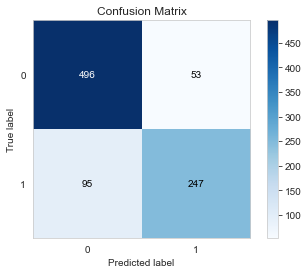

In [19]:
skplt.metrics.plot_confusion_matrix(y, preds_abs["Skl GBM"], normalize=False);

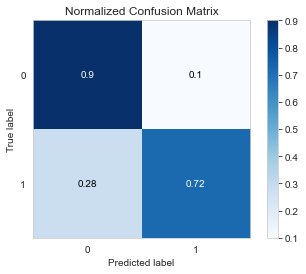

In [20]:
skplt.metrics.plot_confusion_matrix(y, preds_abs["Skl GBM"], normalize=True);

In [21]:
preds_df = pd.DataFrame(preds_pro, index=df.index)
preds_df["Target"] = y
preds_df.head()

,LogRegr,SVM_lin,SVM_rbf,NuSVC,KNN3,KNN5,Decision Tree,Extra Trees,Random Forest,AdaBoost,Skl GBM,Skl HistGBM,XGBoost,LightGBM,CatBoost,Target
PassengerId,,,,,,,,,,,,,,,,
1,0.063260,0.085892,0.136096,0.130633,0.666667,0.4,0.5,0.45,0.259333,0.492282,0.080233,0.102733,0.088350,0.153231,0.091089,0
2,0.969104,0.885993,0.913889,0.895811,1.000000,1.0,1.0,1.00,0.990000,0.509536,0.974341,0.999232,0.999023,0.998332,0.969282,1
3,0.567061,0.762813,0.472855,0.744500,0.666667,0.4,1.0,0.86,0.560000,0.504099,0.350461,0.238632,0.289080,0.360030,0.448011,1
4,0.938988,0.846333,0.886152,0.884355,1.000000,1.0,1.0,1.00,1.000000,0.513650,0.978528,0.999490,0.999782,0.999406,0.961183,1
5,0.073827,0.138047,0.153965,0.145187,0.000000,0.0,0.0,0.00,0.015000,0.495887,0.135855,0.016679,0.018150,0.023411,0.117464,0


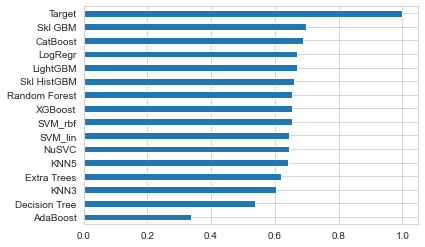

In [22]:
preds_df.corr().Target.sort_values().plot.barh();

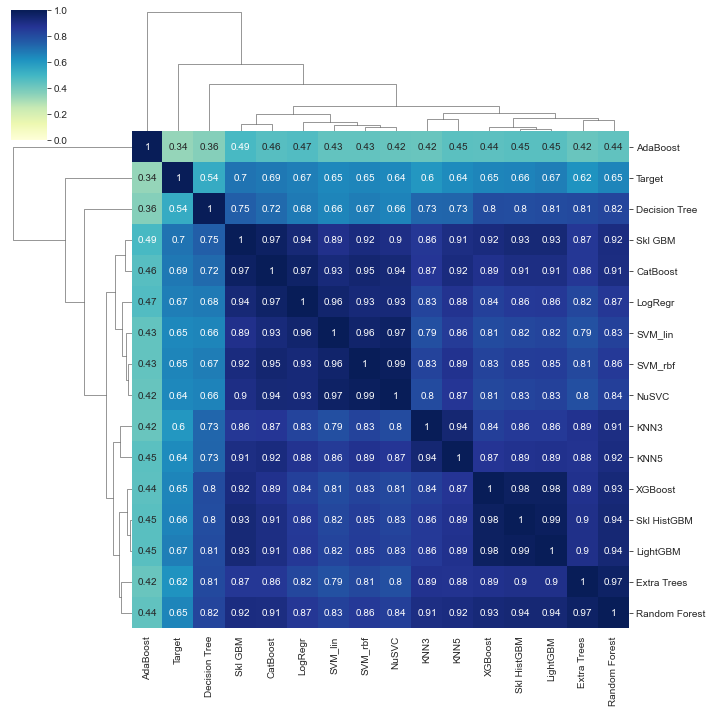

In [23]:
sb.clustermap(preds_df.corr(), cmap="YlGnBu", vmin=0, vmax=1, annot=True);

In [24]:
models["LogRegr"]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked', 'Title']),
                                                 ('age',
                                                  Pipeline(steps=[('imputer',
                                                                   GroupImputer(group_cols=['Sex',
                                                                                            'Pclass',
                                                                                            'Title'],
                                                                                target='Age')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Sex', 'Pclass',
                                                   'Title'])])),
                ('logisticregression', LogisticRegression())])

In [25]:
models_ensemble = [
    ('LightGBM', models["LightGBM"]),
    #('CatBoost', models["CatBoost"]),
    ("LogRegr",  models["LogRegr"]),
    #("KNN5",     models["KNN5"]),
]

ensamble = StackingClassifier(estimators=models_ensemble, cv=20, final_estimator=LogisticRegression())
ensamble

StackingClassifier(cv=20,
                   estimators=[('LightGBM',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=-9999,
                                                                                                                 strategy='constant'))]),
                                                                                  ['Pclass',
                                                                                   'SibSp',
                                                                                   'Parch',
                                                                                   'Fare']),
                                                                                 ('cat',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value='missing',
                                                                                                                 strategy='constant')),
                                                                                                  ('ordinal',
                                                                                                   Ordina...
                                                                                                                 strategy='constant')),
                                                                                                  ('onehot',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['Sex',
                                                                                   'Embarked',
                                                                                   'Title']),
                                                                                 ('age',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   GroupImputer(group_cols=['Sex',
                                                                                                                            'Pclass',
                                                                                                                            'Title'],
                                                                                                                target='Age')),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Age',
                                                                                   'Sex',
                                                                                   'Pclass',
                                                                                   'Title'])])),
                                                ('logisticregression',
                                                 LogisticRegression())]))],
                   final_estimator=LogisticRegression())

In [26]:
ensamble.fit(x,y)

StackingClassifier(cv=20,
                   estimators=[('LightGBM',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=-9999,
                                                                                                                 strategy='constant'))]),
                                                                                  ['Pclass',
                                                                                   'SibSp',
                                                                                   'Parch',
                                                                                   'Fare']),
                                                                                 ('cat',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value='missing',
                                                                                                                 strategy='constant')),
                                                                                                  ('ordinal',
                                                                                                   Ordina...
                                                                                                                 strategy='constant')),
                                                                                                  ('onehot',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['Sex',
                                                                                   'Embarked',
                                                                                   'Title']),
                                                                                 ('age',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   GroupImputer(group_cols=['Sex',
                                                                                                                            'Pclass',
                                                                                                                            'Title'],
                                                                                                                target='Age')),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Age',
                                                                                   'Sex',
                                                                                   'Pclass',
                                                                                   'Title'])])),
                                                ('logisticregression',
                                                 LogisticRegression())]))],
                   final_estimator=LogisticRegression())

In [27]:
test_pred = ensamble.predict(x_test)
test_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [28]:
sub = pd.DataFrame(test_pred, index=x_test.index, columns=["Survived"])
sub.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [29]:
sub.to_csv("sub.csv")

In [33]:
!kaggle competitions submit -c titanic -f sub.csv -m "Ensemble 2"

100%|████████████████████████████████████████| 2.77k/2.77k [00:03<00:00, 740B/s]
Successfully submitted to Titanic - Machine Learning from Disaster